# Main_Quest_02: Motorcycle Night ride

In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


## 프로젝트 수행

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

문제 1. 이미지 세그멘테이션 모델을 만들고,
전체 코드와 분류 결과를 주피터 노트북 파일로 자신의 깃헙에 제출합니다. (2 + 1
점)
- 이미지 데이터를
적절히 전처리 한 후
데이터 파이프라인을
설계합니다.
- 모델은 U-Net으로
고정합니다. 올바른 훈련 진행을 위해
원본에서 변경이 필요할 수 있습니다.
(고정된 모델 이외에
추가모델적용시채점에반영)

## 1. 데이터 준비하기

In [77]:
import os

data_path = os.getenv('HOME')+'/aiffel/workspace/AIFFEL_Quest/Main_Quest_02/images'
print("number of examples :", len(os.listdir(data_path)))

number of examples : 600


In [97]:
# 괄호 안의 숫자를 추출하는 함수
def extract_number_and_type(filename):
    # First, check if the file is of type 'fuse' or 'save'
    if '___fuse' in filename:
        img_type = 'fuse'
    elif '___save' in filename:
        img_type = 'save'
    else:
        img_type = 'img'

    # Extract the number
    match = re.search(r'\((\d+)\)', filename)
    if match:
        number = int(match.group(1))
        return number, img_type
    else:
        return None, None


# 파일 이름에서 숫자를 추출하여 그룹화
def group_images_by_number_and_type(data_path):
    grouped_images = {}
    for img in os.listdir(data_path):
        number, img_type = extract_number_and_type(img)
        if number is not None:
            if number not in grouped_images:
                grouped_images[number] = {'img': [], 'fuse': [], 'save': []}
            grouped_images[number][img_type].append(img)
    return grouped_images

grouped_images = group_images_by_number_and_type(data_path)

# 각 그룹에 3개의 이미지 유형이 존재하는지 확인
for key, group in grouped_images.items():
    for img_type in ['img', 'fuse', 'save']:
        if len(group[img_type]) != 1:
            print(f"Group {key} has {len(group[img_type])} {img_type} images instead of 1.")
            continue

# 그룹을 훈련 및 검증 그룹으로 나누기
all_keys = list(grouped_images.keys())
train_keys, val_keys = train_test_split(all_keys, test_size=0.2, random_state=42)

train_images = []
val_images = []

for key in train_keys:
    train_images.extend(grouped_images[key])
for key in val_keys:
    val_images.extend(grouped_images[key])

print("number of train examples :", len(train_images))
print("number of validation examples :", len(val_images))

number of train examples : 480
number of validation examples : 120


In [98]:
# 이미지 확인
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

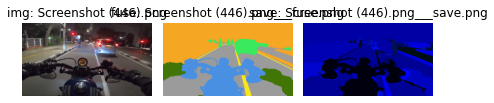

In [100]:
random_group_number = np.random.choice(train_keys)
group_types = grouped_images[random_group_number]

for i, (img_type, filenames) in enumerate(group_types.items(), 1):
    filename = filenames[0]
    f = os.path.join(data_path, filename)
    
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Failed to load image at {f}")
        continue
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 이미지를 읽기 때문에 RGB로 변환
    plt.subplot(1, 3, i)
    plt.title(f"{img_type}: {filename}")
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()


## 2. 이미지 전처리

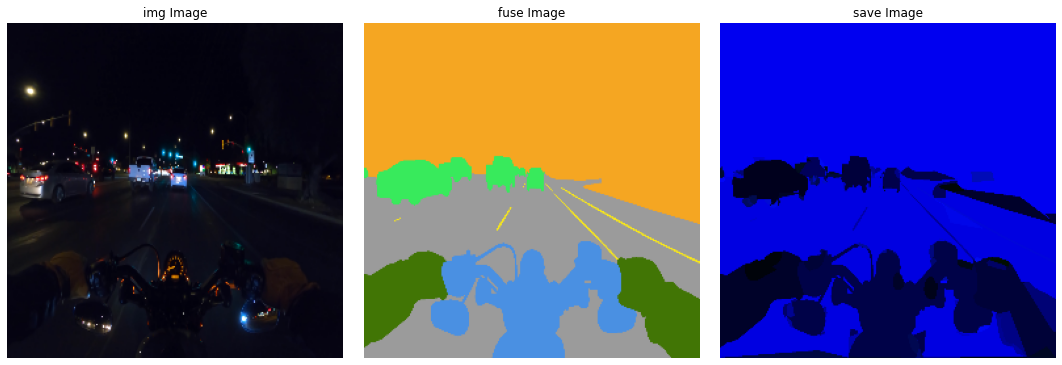

In [103]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_images_by_type(grouped_data, group_number, data_path):
    images_by_type = {}
    for img_type in ['img', 'fuse', 'save']:
        filename = grouped_data[group_number][img_type][0] 
        img_path = os.path.join(data_path, filename)
        img = load_img(img_path)
        images_by_type[img_type] = img
    return images_by_type

# 예제 그룹 번호로 이미지 로드
example_group_number = list(grouped_images.keys())[0]  # 예시를 위한 첫 번째 그룹 번호
loaded_images = load_images_by_type(grouped_images, example_group_number, data_path)

# 로드된 이미지를 시각화
plt.figure(figsize=(15, 5))
for i, (img_type, img) in enumerate(loaded_images.items(), 1):
    plt.subplot(1, 3, i)
    plt.imshow(denormalize(img))
    plt.title(f"{img_type} Image")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Data Augmentation

In [109]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function
def apply_augmentation_to_group(img, fuse, save):
    stacked = tf.concat([img, fuse, save], axis=-1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 9])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[..., :3], out[..., 3:6], out[..., 6:]

print("✅")

✅


In [118]:
augmented_groups = {}

for group_number, image_files in grouped_images.items():
    augmented_groups[group_number] = {
        'aug_img': [],
        'aug_fuse': [],
        'aug_save': []
    }
    
    for i in range(len(image_files['img'])):
        img_path = os.path.join(data_path, image_files['img'][i])
        fuse_path = os.path.join(data_path, image_files['fuse'][i])
        save_path = os.path.join(data_path, image_files['save'][i])

        img = load_img(img_path)
        fuse = load_img(fuse_path)
        save = load_img(save_path)

        aug_img, aug_fuse, aug_save = apply_augmentation_to_group(img, fuse, save)

        augmented_groups[group_number]['aug_img'].append(aug_img)
        augmented_groups[group_number]['aug_fuse'].append(aug_fuse)
        augmented_groups[group_number]['aug_save'].append(aug_save)

### 시각화

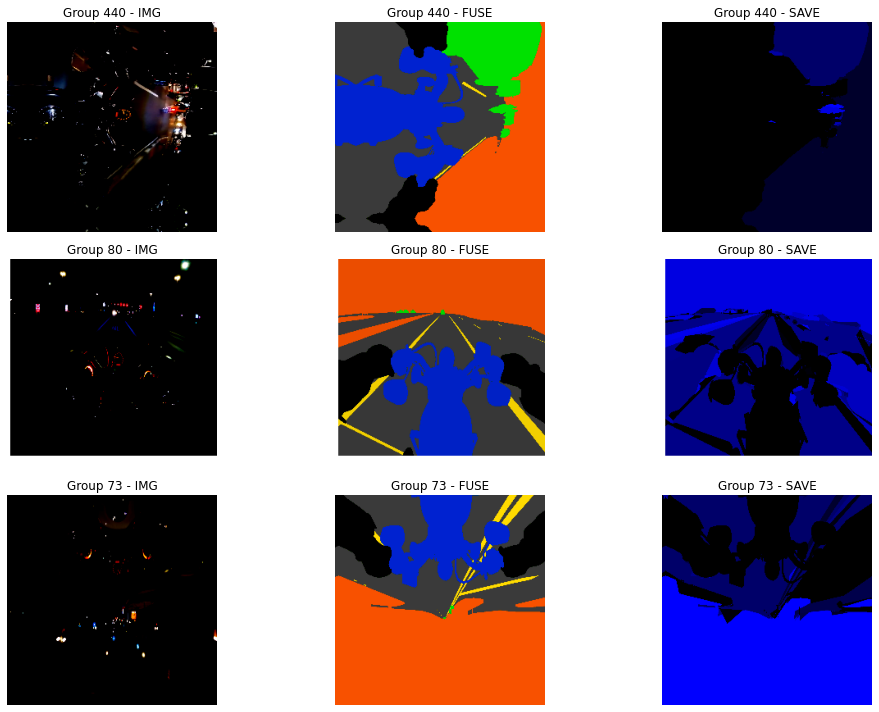

In [121]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def denormalize(image):
    image = tf.cast(image * 255.0, tf.uint8)
    return image

plt.figure(figsize=(15, 10)) 

keys = list(augmented_groups.keys())
selected_keys = np.random.choice(keys, size=3, replace=False)

for idx, key in enumerate(selected_keys):
    aug_imgs = augmented_groups[key]['aug_img']
    aug_fuses = augmented_groups[key]['aug_fuse']
    aug_saves = augmented_groups[key]['aug_save']
    
    random_index = np.random.randint(0, len(aug_imgs))
    
    plt.subplot(3, 3, idx * 3 + 1)
    img_to_show = denormalize(aug_imgs[random_index])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_to_show))
    plt.title(f"Group {key} - IMG")
    plt.axis('off')

    plt.subplot(3, 3, idx * 3 + 2)
    img_to_show = denormalize(aug_fuses[random_index])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_to_show))
    plt.title(f"Group {key} - FUSE")
    plt.axis('off')

    plt.subplot(3, 3, idx * 3 + 3)
    img_to_show = denormalize(aug_saves[random_index])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_to_show))
    plt.title(f"Group {key} - SAVE")
    plt.axis('off')

plt.tight_layout()
plt.show()


- 데이터에 apply augmentation 방법을 적용하여 학습 진행
- 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연사을 두 이미지에 적용

## 3. Generator 구성

skip connection 이 있는 U-Net Generator 를 사용

In [70]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization(momentum=0.9)
        self.lrelu = layers.LeakyReLU(0.1)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization(momentum=0.9)
        self.relu = layers.ReLU(0.1)
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

print("✅")

✅


### 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의

In [71]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### U-Net 구조 Generator 내부 구조 확인

In [72]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 4. Discriminator 구성하기

In [73]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


### Discriminator 만들기

In [74]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
  
print("✅")

✅


### 블록별 출력 크기 확인

In [75]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

### 시각화

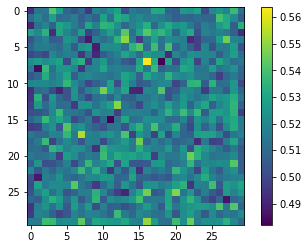

In [76]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 5. 학습 및 테스트

### 손실함수  손실 계산 정의

In [86]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

#Generator
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

#Discriminator
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


### optimizer 설정

In [87]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


### 가중치 업데이트

In [88]:
@tf.function
def train_step(sketch, original):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, original, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, original, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


### 학습

In [93]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (img, fuse, save) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(img, fuse, save)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 20 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[20]                     
Generator_loss:1.3652                     
L1_loss:0.3643                     
Discriminator_loss:0.7721

EPOCH[1] - STEP[40]                     
Generator_loss:1.9274                     
L1_loss:0.2812                     
Discriminator_loss:0.7258

EPOCH[1] - STEP[60]                     
Generator_loss:2.1404                     
L1_loss:0.2904                     
Discriminator_loss:0.4324

EPOCH[1] - STEP[80]                     
Generator_loss:3.0380                     
L1_loss:0.2584                     
Discriminator_loss:0.2940

EPOCH[1] - STEP[100]                     
Generator_loss:3.2765                     
L1_loss:0.3175                     
Discriminator_loss:0.1721

EPOCH[1] - STEP[120]                     
Generator_loss:3.0092                     
L1_loss:0.2721                     
Discriminator_loss:0.1136

EPOCH[1] - STEP[140]                     
Generator_loss:4.1506                     
L1_loss:0.2879                 

EPOCH[5] - STEP[180]                     
Generator_loss:5.3827                     
L1_loss:0.1984                     
Discriminator_loss:0.1152

EPOCH[5] - STEP[200]                     
Generator_loss:4.2265                     
L1_loss:0.2466                     
Discriminator_loss:0.1614

EPOCH[5] - STEP[220]                     
Generator_loss:1.7481                     
L1_loss:0.2402                     
Discriminator_loss:0.3020

EPOCH[5] - STEP[240]                     
Generator_loss:4.8396                     
L1_loss:0.2695                     
Discriminator_loss:0.4570

EPOCH[6] - STEP[20]                     
Generator_loss:4.3175                     
L1_loss:0.1922                     
Discriminator_loss:0.5280

EPOCH[6] - STEP[40]                     
Generator_loss:6.0167                     
L1_loss:0.2089                     
Discriminator_loss:0.3666

EPOCH[6] - STEP[60]                     
Generator_loss:4.0173                     
L1_loss:0.2656                

EPOCH[10] - STEP[100]                     
Generator_loss:2.4346                     
L1_loss:0.1973                     
Discriminator_loss:0.2833

EPOCH[10] - STEP[120]                     
Generator_loss:2.7124                     
L1_loss:0.1679                     
Discriminator_loss:0.3539

EPOCH[10] - STEP[140]                     
Generator_loss:4.7855                     
L1_loss:0.2143                     
Discriminator_loss:0.5762

EPOCH[10] - STEP[160]                     
Generator_loss:2.6032                     
L1_loss:0.2075                     
Discriminator_loss:0.3290

EPOCH[10] - STEP[180]                     
Generator_loss:1.9780                     
L1_loss:0.2390                     
Discriminator_loss:0.2391

EPOCH[10] - STEP[200]                     
Generator_loss:2.7395                     
L1_loss:0.2097                     
Discriminator_loss:0.1926

EPOCH[10] - STEP[220]                     
Generator_loss:1.7098                     
L1_loss:0.2007      

### 채색하기

## 회고

전처리 과정에서 시간이 너무 잡아먹었다. 나중에 다시 해보아야겠다.